# Master PCS - Out of Equilibrium statistical physics
## Homework problem
### __Simulating lattice model of surface groth__
Joseph Touzet

In [1]:
import numpy as np
from matplotlib import pyplot as plt

We first implement the two deposition model: RDR and SOS.

In [2]:
def gen_starting_state(L):
    return np.zeros(L)

def gen_starting_states(L, n):
    return np.zeros((n, L))

In [3]:
def step_RDR(h):
    L = len(h)
    
    idx = np.random.randint(0, L)
    idx_left  = (idx-1+L)%L
    idx_right = (idx+1  )%L
    
    if  h[idx_left]  < h[idx_right]:
        h[idx_left]  += 1
    elif h[idx_left] > h[idx_right]:
        h[idx_right] += 1
    else:
        if np.random.rand() < 0.5:
            h[idx_left]  += 1
        else:
            h[idx_right] += 1
    
    return h

def simulate_RDR(h, t):
    for i in range(int(t)):
        h = step_RDR(h)
    return h

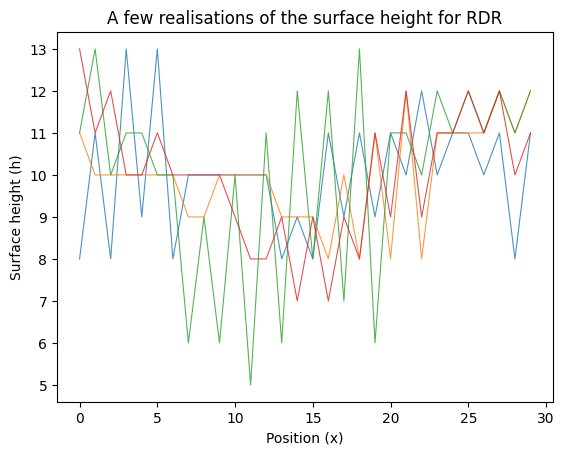

In [4]:
states = gen_starting_states(30, 4)
for i in range(states.shape[0]):
    states[i, :] = simulate_RDR(states[i, :], states.shape[1]*10)

plt.plot(states.T, alpha=0.8, linewidth=0.8)

plt.xlabel("Position (x)")
plt.ylabel("Surface height (h)")
plt.title("A few realisations of the surface height for RDR")
plt.show()

In [5]:
def step_SOS(h):
    L = len(h)
    
    idx = np.random.randint(0, L)
    idx_left  = (idx-1+L)%L
    idx_right = (idx+1  )%L

    if abs(h[idx_left] - (h[idx]+1)) <= 1 and abs((h[idx]+1) - h[idx_right]) <= 1:
        h[idx] += 1
    
    return h

def simulate_SOS(h, t):
    for i in range(int(t)):
        h = step_SOS(h)
    return h

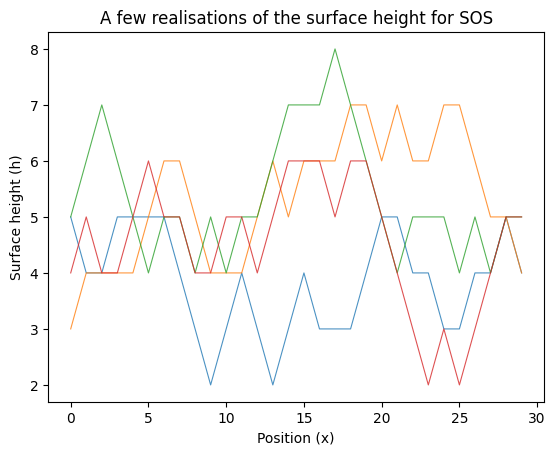

In [6]:
states = gen_starting_states(30, 4)
for i in range(states.shape[0]):
    states[i, :] = simulate_SOS(states[i, :], states.shape[1]*10)

plt.plot(states.T, alpha=0.8, linewidth=0.8)

plt.xlabel("Position (x)")
plt.ylabel("Surface height (h)")
plt.title("A few realisations of the surface height for SOS")
plt.show()

We also need to implement a function to compute the roughness:

We first note that $W(L, t)^2 = \left< \overline{(h - \overline{h})^2} \right> = \left< std(h) \right> $

In [7]:
def compute_Wsqr_single(h):
    return np.std(h)

def compute_W(L, ts, simulator, n_it):
    Wsqr = np.zeros(len(ts))

    # for n_it strating graphs:
    for n in range(int(n_it)):
        h = gen_starting_state(L)

        # for all times ts:
        for i in range(len(ts)):
            # iterate the right amount of iteration to have a total of ts[i] iterations
            t = ts[i] - (0 if i == 0 else ts[i-1])    
            h = simulator(h, t)

            # accumulate the roughness
            Wsqr[i] += compute_Wsqr_single(h)

    # and copute the final average roughness:
    Wsqr_avg = Wsqr / n_it
    W = np.sqrt(Wsqr_avg)
    
    return W

def compute_W_RDR(L, ts, n_it):
    return compute_W(L, ts, simulate_RDR, n_it)
    
def compute_W_SOS(L, ts, n_it):
    return compute_W(L, ts, simulate_SOS, n_it)

Finally, we implement a function to compute the probability of deviation of $h_i$ around $\overline{h}$:

In [8]:
def compute_deviation_probability(L, ts, simulator, n_it, dev_lim):
    dev = np.zeros((len(ts), 2*dev_lim+1))
    
    # for n_it strating graphs:
    for n in range(int(n_it)):
        h = gen_starting_state(L)
        
        # for all times ts:
        for i in range(len(ts)):
            # iterate the right amount of iteration to have a total of ts[i] iterations
            t = ts[i] - (0 if i == 0 else ts[i-1])    
            h = simulator(h, t)

            # accumulate the number of occurences for each deviation (dev in [[-dev_lim, +dev_lim]] )
            avg_h = int(np.round(np.mean(h)))
            for j in range(-dev_lim, dev_lim+1):
                dev[i,dev_lim+j] += np.mean(h == avg_h+j)

    # compute the probability:
    dev = dev / n_it
    return dev

def compute_deviation_probability_RDR(L, ts, n_it, dev_lim):
    return compute_deviation_probability(L, ts, simulate_RDR, n_it, dev_lim)
    
def compute_deviation_probability_SOS(L, ts, n_it, dev_lim):
    return compute_deviation_probability(L, ts, simulate_SOS, n_it, dev_lim)

(1) TODO

In [9]:
L, n_it = 500, 200
ts      = np.round(L*(np.linspace(0.5,5,20))**2)

In [10]:
W_RDR = compute_W_RDR(L, ts, n_it)

In [11]:
W_SOS = compute_W_SOS(L, ts, n_it)

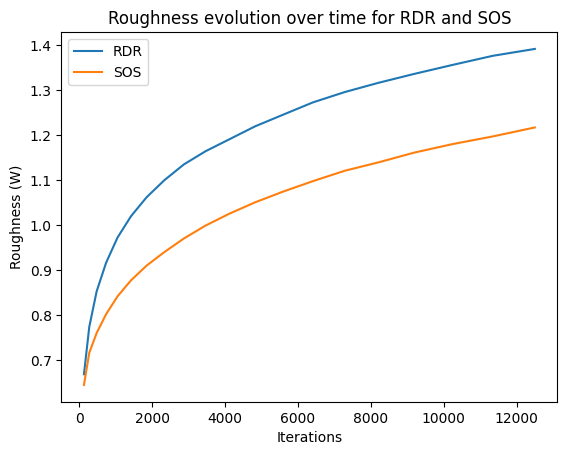

In [12]:
plt.plot(ts, W_RDR, label="RDR")
plt.plot(ts, W_SOS, label="SOS")

plt.xlabel("Iterations")
plt.ylabel("Roughness (W)")
plt.title("Roughness evolution over time for RDR and SOS")
#plt.xscale("log")
#plt.yscale("log")

plt.legend()
plt.show()

(2) TODO

In [13]:
L, n_it  = 500, 400
ts_small = np.linspace(1,L)

In [14]:
W_RDR_small = compute_W_RDR(L, ts_small, n_it)

In [15]:
W_SOS_small = compute_W_SOS(L, ts_small, n_it)

In [16]:
a_RDR, b_RDR = np.polyfit(np.log(ts_small[:6]), np.log(W_RDR_small[:6]), 1)
a_SOS, b_SOS = np.polyfit(np.log(ts_small[:6]), np.log(W_SOS_small[:6]), 1)

print(round(a_RDR, 3), round(a_SOS, 3))

0.243 0.24


We get $\beta \approx 1/4$, thus both models are in the equivalence class of interface models.

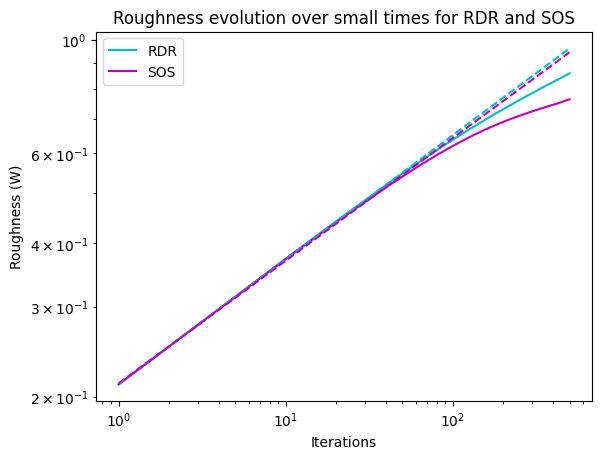

In [17]:
plt.plot(ts_small, W_RDR_small, "c-", label="RDR")
plt.plot(ts_small, W_SOS_small, "m-", label="SOS")

plt.plot(ts_small, np.exp(b_RDR)*(ts_small**a_RDR), "c--")
plt.plot(ts_small, np.exp(b_SOS)*(ts_small**a_SOS), "m--")

plt.xlabel("Iterations")
plt.ylabel("Roughness (W)")
plt.title("Roughness evolution over small times for RDR and SOS")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

(3) TODO

(4) TODO

In [18]:
L, n_it = 300, 200
ts      = np.round(L*(np.linspace(0.5,5,5))**2)
max_dev = 6

In [19]:
dev_proba_RDR = compute_deviation_probability_RDR(L, ts, n_it, max_dev)

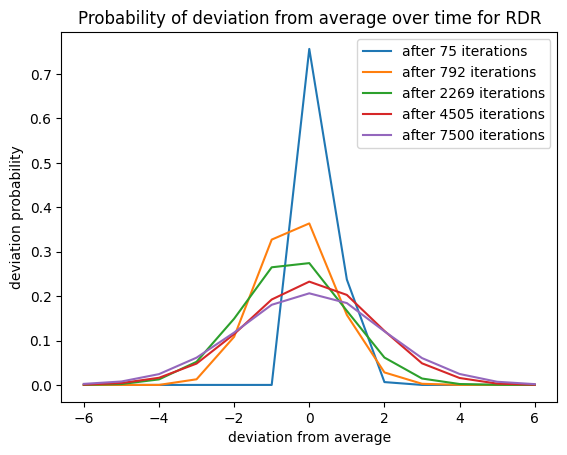

In [20]:
for data,t in zip(dev_proba_RDR,ts):
    plt.plot(np.arange(-max_dev, max_dev+1), data, label=f"after {int(t)} iterations")

plt.xlabel("deviation from average")
plt.ylabel("deviation probability")
plt.title("Probability of deviation from average over time for RDR")
plt.legend()
plt.show()

In [21]:
dev_proba_SOS = compute_deviation_probability_SOS(L, ts, n_it, max_dev)

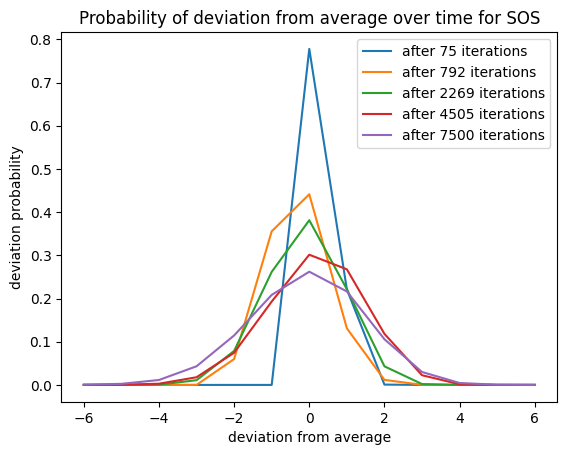

In [22]:
for data,t in zip(dev_proba_SOS,ts):
    plt.plot(np.arange(-max_dev, max_dev+1), data, label=f"after {int(t)} iterations")

plt.xlabel("deviation from average")
plt.ylabel("deviation probability")
plt.title("Probability of deviation from average over time for SOS")
plt.legend()
plt.show()

Blaba...